In the event that a video creator's content is deemed inappropriate by YouTube—for example, due to content that is sensitive to children, uses vulgar language, or advertises firearms—the creator will be permanently banned from the platform upon channel deletion.

Rumble emerged as an alternative video streaming platform with fewer regulations, and many content creators have moved to it.

In this notebook, the voltaility of Rumbled is investigated using the well-known ARCH(1) model, and the results are compared to the implied voltality of call options involving Rumble.  The Black-Scholes formula is used to calculate implied voltality.  Once the observed price of the call/put option is known, the formula can calculate the implied voltality that the trading platform used to price the option.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize

Rumble stock prices from 1st of January 2022 to the 16th of May 2025 is obtained from investing.com:

In [47]:
data = pd.read_csv('Rumble Stock Price History.csv') # Importing the dataframe
data.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,1/3/2022,11.25,11.02,11.47,10.77,2.23M,3.88%
1,1/4/2022,11.48,11.37,11.62,11.11,1.75M,2.04%
2,1/5/2022,11.92,11.49,12.56,11.39,4.41M,3.83%
3,1/6/2022,12.17,12.00,12.41,11.20,4.40M,2.10%
4,1/7/2022,11.62,11.89,12.10,11.56,1.98M,-4.52%


In [48]:
data['Change %'] =data['Change %'].str.replace('%','').astype(float) # adjusting column types
data['Change %'] =data['Change %']
data['Price'] = data['Price'].astype(float)
data.dtypes

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %    float64
dtype: object

In [49]:
data.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,1/3/2022,11.25,11.02,11.47,10.77,2.23M,3.88
1,1/4/2022,11.48,11.37,11.62,11.11,1.75M,2.04
2,1/5/2022,11.92,11.49,12.56,11.39,4.41M,3.83
3,1/6/2022,12.17,12.00,12.41,11.20,4.40M,2.10
4,1/7/2022,11.62,11.89,12.10,11.56,1.98M,-4.52


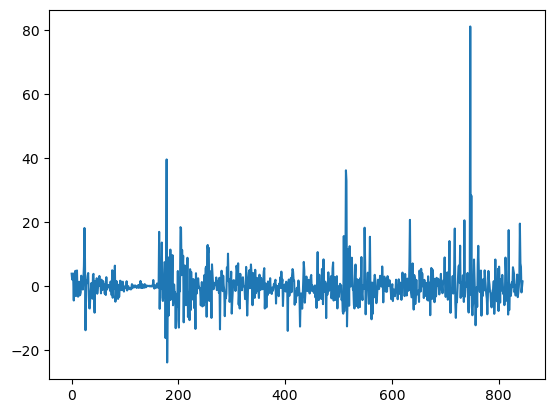

In [50]:
plt.plot(np.arange(len(data['Change %'])), data['Change %'])

The Exponential moving average is usually used to obtain an estimate of the voltality.
First, the sample average of returns $\bar r$ is calculated, then the square of excess returns is treated as the historical voltality, i.e., $(r_t - \bar r)^2$

In [51]:
r_t = (data['Change %'] - data['Change %'].mean())**2 
r_t.mean()

36.07529051090097

Most of the times $\bar r$ is set equal to zero, this is especially true in our case where the estimate obtained is very close to zero.
$$\bar r = 0.157 \% $$

The EWMA reconstructed series of squared excess returns is given by:
$$ \sigma^2_{t} = (1- \lambda) \sum{\lambda_{j} (r_{t-j} - \bar r)^2} $$

As mentioned in Brooks textbook, the decay factor $\lambda$ is set equal to 0.94 as a popular software for risk assessment suggests.

The estimated voltalit is the value of the filtered series at the end of the sample, that is $\sigma^2_{T}$

$$\sigma_{Daily,EWMA} = \sqrt{\sigma^2_{T}} = 5.836 \% $$

In [52]:
sigma_sq = np.zeros(len(r_t)) # Create a series of zeros
sigma_sq[0] = r_t[0] # initialize the series with first observation
for i in range (len(r_t) - 1):
    sigma_sq[i+1] = (1-0.94)*r_t[i+1] + 0.94*sigma_sq[i]

np.sqrt(sigma_sq[len(r_t)-1]) # the last value of the filtered series of squared excess returns


5.836839669917113

The ARCH(1) model:

ARCH model places a constraint on the residuals of the returns, assuming that they are linaer projections of their past.

$$ r_t = \mu + \epsilon_t $$
Instead of assuming $\epsilon_t$ being  a white noise, the conditional distribution of $\epsilon_t$ is given by:

$$ \epsilon_t = \sqrt h_t * v_t $$
Where $v_t$ is a gaussian distributed as N(0,1), and $ h_t = \alpha_0 + \alpha_1 \epsilon_{t-1} $

This assumptions has implications on the likelihood of $r_t$ which is now a gaussian with mean $\mu$ and variance $h_t$

$$ \ell(r_t;\bold{\theta}) = -\frac{T}{2}\log(2\pi) - \frac{T}{2}\sum{\log(h_t)}  - \frac{1}{2} \sum{\frac{(r_t - \mu)}{h_t}}  $$

In [53]:
#Estimating the coefficients and the carry-over parameter:
#The likelihood function:
def log_likelihood(p,y):
    mu_hat = p[0]
    alpha0_hat = p[1]
    alpha1_hat = p[2]
    y_star = (y - mu_hat)**2
    h = np.zeros(len(y))
    h[0] = y_star[0]#initializing the error term
    for i in range(len(y)-1):
      h[i+1] = alpha0_hat + alpha1_hat*y_star[i] 

    l = -0.5*(len(y))*np.log(2*np.pi) - 0.5*np.sum(np.log(h))- np.sum((y - mu_hat)**2/(2*h))
    return -l


In [54]:
p0 = [0.15,0.37,0.13]
ll = log_likelihood(p0, data['Change %'])
ll

15260.438462170361

In [55]:
def constraint(p):
    alpha0_hat = p[1]
    alpha1_hat = p[2]
    return alpha0_hat, alpha1_hat

cons = { 'type' :'ineq' , 'fun' : constraint}

In [56]:
minimize(log_likelihood, p0, args= (data['Change %']), constraints= cons, options={"maxiter": 1000} )

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2698.163769186841
       x: [ 1.042e-01  3.149e+01  1.363e-01]
     nit: 25
     jac: [ 7.935e-04  1.221e-04  4.181e-03]
    nfev: 119
    njev: 25

The unconditional variance as given by the ARCH(1) model is given by:

$$ \sigma^2 = \frac{\alpha_0}{1- \alpha_1} $$

And the estimated daily voltality will be:

$$ \sigma_{Daily,ARCH} = \sqrt{\sigma^2_{ARCH}} $$

In [57]:
# The unconditional voltality:
sigma_sq_uncon = np.sqrt(3.149e+01/(1-1.363e-01))
sigma_sq_uncon

6.038163527072521

In [58]:
data.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,1/3/2022,11.25,11.02,11.47,10.77,2.23M,3.88
1,1/4/2022,11.48,11.37,11.62,11.11,1.75M,2.04
2,1/5/2022,11.92,11.49,12.56,11.39,4.41M,3.83
3,1/6/2022,12.17,12.00,12.41,11.20,4.40M,2.10
4,1/7/2022,11.62,11.89,12.10,11.56,1.98M,-4.52


At 16/5/2025 the implied volatlity on a call option on Rumble expiring at 30/5/2025 at a strike price of 6 USD and trading at 4.5 USD was 192.97%

The volatlity estimated through the ARCH(1) model was 6.038%, but this is a voltality estimated on daily basis.

A huerstic solution (https://gregorygundersen.com/blog/2022/05/24/square-root-of-time-rule/) can be found by placing few assumptions on the random variable $ Y_T $ that is formed by the sum of i.i.d random variables, i.e, $ X_i $
$$ Y_T =  X_{1} + X_{2} + X_{3} + X_{4} + ... + X_{T}  $$

Here the ${X_i}$ represent the sequence of daily returns, and $Y_T$ might be monthly returns, weekly or even yearly. Any lower frequency than the original one for which the model for voltality was developed.
$$ Var [Y_T] =  Var [ \sum{X_i} ] = \sum[Var[X_i]]  = T Var[X_i] $$

Therefore, under the assumption of returns being drawn from an i.i.d distribution, the estimate of the daily voltality can be rescaled. In our case, annually there are 252 trading days in a year (T = 252).

$$ \sigma_{Annual,ARCH} =  \sqrt{T} \sigma_{Daily,ARCH} $$

$$ \sigma_{Annual,ARCH} =  \sqrt{252} * 6.038 \%  = 95.852 \%$$


In [59]:
sigma_sq_uncon*np.sqrt(252)

95.85287440904709

Comments: The annualized volatility as given by the ARCH(1) model seems to be sigficantly underestimated as compared to the estimates used in options valuations!